In [35]:
import os
import json
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Construct the base path relative to the current working directory
base_path = os.path.join(os.getcwd(), '..', '..', 'Data', 'CVE', 'cves')

data = []

# Traverse the directory tree
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                cve_data = json.load(f)
                if isinstance(cve_data, dict):
                    cveId = cve_data.get('cveMetadata', {}).get('cveId')
                    shortName = cve_data.get('cveMetadata', {}).get('assignerShortName')
                    datePublished = cve_data.get('cveMetadata', {}).get('datePublished')
                    data.append({
                        'cveId': cveId,
                        'shortName': shortName,
                        'datePublished': datePublished
                    })

# Create DataFrame
cve_df = pd.DataFrame(data)

# Rename columns
cve_df.rename(columns={
    'cveId': 'CVE',
    'shortName': 'CNA',
    'datePublished': 'Date'
}, inplace=True)

# Convert 'Date' using regex
cve_df['Date'] = cve_df['Date'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group(0) if pd.notna(x) else None)

# Convert 'Date' to datetime
cve_df['Date'] = pd.to_datetime(cve_df['Date'], errors='coerce')

# Drop rows with NaT values in the Date column after conversion 
cve_df = cve_df.dropna(subset=['Date'])

# Capitalize the CNA names
cve_df['CNA'] = cve_df['CNA'].str.capitalize()

# Display the DataFrame
cve_df

,CVE,CNA,Date
1,CVE-2013-2824,Icscert,2014-02-26
2,CVE-2013-2127,Redhat,2013-08-14
3,CVE-2013-2577,Mitre,2013-08-09
4,CVE-2013-2598,Mitre,2014-08-31
5,CVE-2013-2062,Redhat,2013-06-15
...,...,...,...
284249,CVE-2004-1419,Mitre,2005-02-12
284250,CVE-2004-1675,Mitre,2005-02-20
284251,CVE-2004-1225,Mitre,2004-12-15
284252,CVE-2004-1730,Mitre,2005-02-26


In [37]:
# Get today's date
today = pd.Timestamp.today()

# Calculate the date one year ago from today
one_year_ago = today - pd.DateOffset(years=1)

# Filter the DataFrame for CVEs from the last year
last_year_cves = cve_df[cve_df['Date'] >= one_year_ago]

# Display the filtered DataFrame
last_year_cves

,CVE,CNA,Date
13133,CVE-2014-125110,Vuldb,2024-03-31
13149,CVE-2014-125111,Vuldb,2024-04-08
14874,CVE-2014-5470,Mitre,2024-06-21
15844,CVE-2022-2440,Wordfence,2024-08-29
16028,CVE-2022-2446,Wordfence,2024-09-13
...,...,...,...
265468,CVE-2016-20022,Mitre,2024-06-27
266529,CVE-2016-10408,Qualcomm,2024-11-26
266774,CVE-2016-10394,Qualcomm,2024-11-26
274776,CVE-2005-10003,Vuldb,2024-10-17


In [38]:
# Get today's date
today = pd.Timestamp.today()

# Calculate the date one year ago from today
one_year_ago = today - pd.DateOffset(years=1)

# Filter the DataFrame for CVEs from the last year
last_year_cves = cve_df[cve_df['Date'] >= one_year_ago]

# Calculate the total number of days in the period
total_days = (today - one_year_ago).days

# Calculate the total number of CVEs each CNA published in the last year
cna_total_cves = last_year_cves.groupby('CNA').size().reset_index(name='Total_CVEs')

# Add the total number of days to the DataFrame
cna_total_cves['Total_Days'] = total_days

# Calculate the average number of CVEs per day for each CNA
cna_total_cves['Average_CVEs_per_day'] = cna_total_cves['Total_CVEs'] / cna_total_cves['Total_Days']

# Sort the DataFrame by 'Average_CVEs_per_day' in descending order
cna_total_cves = cna_total_cves.sort_values(by='Average_CVEs_per_day', ascending=False)

# Display the DataFrame
cna_total_cves

,CNA,Total_CVEs,Total_Days,Average_CVEs_per_day
167,Mitre,6116,365,16.756164
209,Patchstack,5893,365,16.145205
155,Linux,5219,365,14.298630
296,Wordfence,4042,365,11.073973
288,Vuldb,2979,365,8.161644
...,...,...,...,...
174,Ncsc-fi,1,365,0.002740
148,Krcert,1,365,0.002740
146,Knime,1,365,0.002740
130,Ict,1,365,0.002740


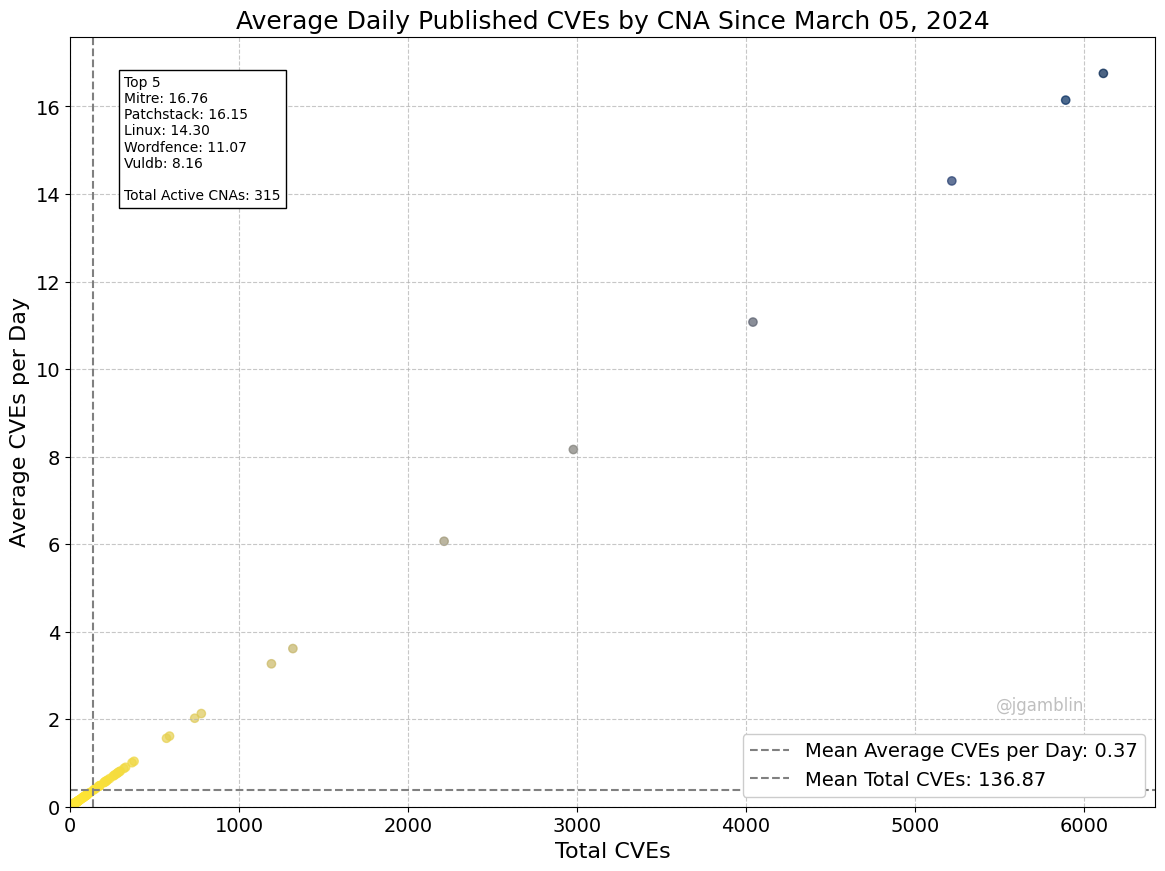

In [39]:
# Set the font family to 'DejaVu Sans'
plt.rcParams['font.family'] = 'DejaVu Sans'

# Calculate the mean of 'Average_CVEs_per_day' and 'Total_CVEs'
mean_average_cves_per_day = cna_total_cves['Average_CVEs_per_day'].mean()
mean_total_cves = cna_total_cves['Total_CVEs'].mean()

# Get the date one year ago and format it as "Month Day, Year"
one_year_ago_str = one_year_ago.strftime('%B %d, %Y')

# Calculate the total number of active CNAs
total_active_cnas = cna_total_cves['CNA'].nunique()

# Create a scatter plot of 'Total_CVEs' vs 'Average_CVEs_per_day' with a colormap
plt.figure(figsize=(14, 10))
scatter = plt.scatter(cna_total_cves['Total_CVEs'], cna_total_cves['Average_CVEs_per_day'], 
                      c=cna_total_cves['Average_CVEs_per_day'], cmap='cividis_r', alpha=0.7)

# Add a horizontal line for the mean of 'Average_CVEs_per_day'
plt.axhline(y=mean_average_cves_per_day, color='grey', linestyle='--', label=f'Mean Average CVEs per Day: {mean_average_cves_per_day:.2f}')

# Add a vertical line for the mean of 'Total_CVEs'
plt.axvline(x=mean_total_cves, color='grey', linestyle='--', label=f'Mean Total CVEs: {mean_total_cves:.2f}')

# Add labels and title with increased font size
plt.xlabel('Total CVEs', fontsize=16)
plt.ylabel('Average CVEs per Day', fontsize=16)
plt.title(f'Average Daily Published CVEs by CNA Since {one_year_ago_str}', fontsize=18)

# Set axis limits to start from 0,0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add grid with a lighter color
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend with a border, move it to the bottom right, and make it opaque
plt.legend(frameon=True, fontsize=14, loc='lower right', framealpha=1.0)

# Increase the font size of the ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Get the top five CNAs by 'Average_CVEs_per_day'
top_five_cnas = cna_total_cves.nlargest(5, 'Average_CVEs_per_day')

# Create a list of the top five CNAs with their average CVEs per day
top_five_list = [f"{row.CNA}: {row.Average_CVEs_per_day:.2f}" for row in top_five_cnas.itertuples()]

# Add the list to the upper left-hand corner of the plot
ranking_text = f"Top 5\n" + "\n".join(top_five_list) + f"\n\nTotal Active CNAs: {total_active_cnas}"
plt.text(0.05, 0.95, ranking_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=1.0))

# Add a watermark
plt.text(0.935, 0.12, '@jgamblin', fontsize=12, color='grey', ha='right', va='bottom', alpha=0.5, transform=plt.gca().transAxes)

# Save the plot as a PNG file
plt.savefig('average_daily_published_cves_by_cna.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()